In [4]:
import numpy as np
import os
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
import dask.array as da

robert a adams first course calculus (earlier version)

In [5]:
# reading in ERA5 to compare

base_path = '/data/rong4/Data/ERA5/3hourly/quvw_US'

# Define the range of years and months
years = [str(year) for year in range(1979, 2019)]

def get_files(folder, component):

    files = glob.glob(os.path.join(base_path, folder, f"era5.{component}.*.nc"))

    filtered_files = [f for f in files if any(year in f for year in years)]
    
    return filtered_files

# Get the files for each component
u_files = get_files('u_component_of_wind', 'u_component_of_wind')

v_files = get_files('v_component_of_wind', 'v_component_of_wind')

q_files = get_files('specific_humidity', 'specific_humidity')

all_files = u_files + v_files + q_files

# open all datasets at once
era5 = xr.open_mfdataset(all_files, combine='by_coords', chunks={'time': 24})

era5sgp = era5.sel(latitude=slice(39.0, 30.0), longitude=slice(-105.0, -95.0))

era5sgp['time'] = era5sgp['time'] - pd.Timedelta(hours=6)

In [6]:
#subsetting for 2011
era2011 = era5sgp.where(era5sgp['time'].dt.year == 2011, drop=True)

night = era2011.sel(time=era2011['time'].dt.hour.isin([0, 6]))

day = era2011.sel(time=era2011['time'].dt.hour.isin([12, 18]))

full = era2011.sel(time=era2011['time'].dt.hour.isin([0, 6, 12, 18]))

night = night.resample(time='ME').mean()

day = day.resample(time='ME').mean()

full = full.resample(time='ME').mean()

In [7]:
#subsetting for climatology
clim = era5sgp.sel(time=slice('1979-01-01', '2018-12-31'))

cnight = clim.sel(time=clim['time'].dt.hour.isin([0, 6]))

cday = clim.sel(time=clim['time'].dt.hour.isin([12, 18]))

cfull = clim.sel(time=clim['time'].dt.hour.isin([0, 6, 12, 18]))

cnight = cnight.groupby('time.month').mean('time')

cday = cday.groupby('time.month').mean('time')

cfull = cfull.groupby('time.month').mean('time')

In [8]:
all_times = {
    
    'clim full': cfull,
    
    '2011 night': night,
    
    '2011 day': day,
        
    'clim night': cnight,
    
    'clim day': cday 
    
}

In [25]:
def calculate_advection(u, v, q, lat, lon):

    R = 6371000  # radius of Earth (meters)
    
    rho_water = 1000 # kg/m^3
    
    seconds_to_day = 60 * 60 * 24 # to convert from s --> day

    latitude_range = np.sin(np.radians(lat[-1])) - np.sin(np.radians(lat[0]))
    
    longitude_range = np.radians(lon[-1]) - np.radians(lon[0])
    
    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    
    delta_y = np.radians(lat[1]) - np.radians(lat[0])
    delta_x = np.radians(lon[1]) - np.radians(lon[0])
    
    # shaped as (#lons, #lats) so first row represents all values for first latitude (eg: 30,30,30...)
    cos_correction = np.cos(lat_grid)
    
    dqdx = np.zeros_like(q)
    dqdy = np.zeros_like(q)
    
    # Loop through each pressure level
    for k in range(u.shape[0]):
        
        # Central points
    
        dqdx[k, :, 1:-1] = (q[k, :, 2:] - q[k, :, :-2]) / (2 * delta_x)
        dqdy[k, 1:-1, :] = (q[k, 2:, :] - q[k, :-2, :]) / (2 * delta_y)
        
        # Left and right boundaries (x-direction)
        
        dqdx[k, :, 0] = (q[k, :, 1] - q[k, :, 0]) / (delta_x)
        dqdx[k, :, -1] = (q[k, :, -2] - q[k, :, -1]) / (delta_x)

        # Top and bottom boundaries (y-direction)
        
        dqdy[k, 0, :] = (q[k, 1, :] - q[k, 0, :]) / (delta_y)
        dqdy[k, -1, :] = (q[k, -2, :] - q[k, -1, :]) / (delta_y)
        
        dx = R * cos_correction * delta_x
        dy = R * delta_y

        # for every grid point, multiply by the area extent of that grid box 
        
        dqdy[k] = (1/R) * dqdy[k] * dx * dy
        
        dqdx[k] = (1/(R*cos_correction)) * dqdx[k] * dx * dy
        
    meridional_advection = -(v * dqdy)
    
    zonal_advection = -(u * dqdx)
    
    total_area = []
    
    for i in dx: 
        
        total_area.append(i*dy)
        
    A = np.sum(total_area)
    
    # Area weighted average
    zonal_advection_area_weighted = np.sum(zonal_advection, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    meridional_advection_area_weighted = np.sum(meridional_advection, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    # Units = mm/day 
    # Shapes returned: (#pressure levels) because advection is averaged over the domain for every level 

    return zonal_advection_area_weighted, meridional_advection_area_weighted

In [44]:
def calculate_convergence(u, v, q, lat, lon):

    R = 6371000  # radius of Earth (meters)
    
    rho_water = 1000 # kg/m^3
    
    seconds_to_day = 60 * 60 * 24 # to convert from s --> day

    latitude_range = np.sin(np.radians(lat[-1])) - np.sin(np.radians(lat[0]))
    
    longitude_range = np.radians(lon[-1]) - np.radians(lon[0])
    
    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    
    delta_y = np.radians(lat[1]) - np.radians(lat[0])
    delta_x = np.radians(lon[1]) - np.radians(lon[0])
    
    # shaped as (#lons, #lats) so first row represents all values for first latitude (eg: 30,30,30...)
    cos_correction = np.cos(lat_grid)
    
    v_scaled = v*cos_correction
    
    dudx = np.zeros_like(u)
    dvdy = np.zeros_like(v)
    
    # Loop through each pressure level
    for k in range(u.shape[0]):
        
        # Central points
        dudx[k, :, 1:-1] = (u[k, :, 2:] - u[k, :, :-2]) / (2 * delta_x)
        dvdy[k, 1:-1, :] = (v_scaled[k, 2:, :] - v_scaled[k, :-2, :]) / (2 * delta_y)
        
        # Left and right boundaries (x-direction)
        dudx[k, :, 0] = (u[k, :, 1] - u[k, :, 0]) / (delta_x)
        dudx[k, :, -1] = (u[k, :, -2] - u[k, :, -1]) / (delta_x)

        # Top and bottom boundaries (y-direction)
        dvdy[k, 0, :] = (v_scaled[k, 1, :] - v_scaled[k, 0, :]) / (delta_y)
        dvdy[k, -1, :] = (v_scaled[k, -2, :] - v_scaled[k, -1, :]) / (delta_y)
        
        dx = R * cos_correction * delta_x
        dy = R * delta_y

        # for every grid point, multiply by the area extent of that grid box 
        dudx[k] = (1/(R*cos_correction)) * dudx[k] * dx * dy
        
        dvdy[k] = (1/(R*cos_correction)) * dvdy[k] * dx * dy
        
    zonal_convergence = -(q * dudx)
    
    meridional_convergence = -(q * dvdy)
    
    total_area = []
    
    for i in dx: 
        
        total_area.append(i*dy)
        
    A = np.sum(total_area)
    
    # Area weighted average
    zonal_convergence_area_weighted = np.sum(zonal_convergence, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    meridional_convergence_area_weighted = np.sum(meridional_convergence, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    # Units = mm/day 
    # Shapes returned: (#pressure levels) because advection is averaged over the domain for every level 

    return zonal_convergence_area_weighted, meridional_convergence_area_weighted

In [54]:
def calculate_mfc(u, v, q, lat, lon):

    R = 6371000  # radius of Earth (meters)
    
    rho_water = 1000 # kg/m^3
    
    seconds_to_day = 60 * 60 * 24 # to convert from s --> day

    latitude_range = np.sin(np.radians(lat[-1])) - np.sin(np.radians(lat[0]))
    
    longitude_range = np.radians(lon[-1]) - np.radians(lon[0])
    
    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    
    delta_y = np.radians(lat[1]) - np.radians(lat[0])
    delta_x = np.radians(lon[1]) - np.radians(lon[0])
    
    # shaped as (#lons, #lats) so first row represents all values for first latitude (eg: 30,30,30...)
    cos_correction = np.cos(lat_grid)
    
    v_scaled = v*cos_correction
    
    # defining the flux which we take derivates of 
    uq = u*q
    vq = v_scaled*q
    
    duqdx = np.zeros_like(uq)
    dvqdy = np.zeros_like(vq)
    
    # Loop through each pressure level
    for k in range(u.shape[0]):
        
        # Central points
        duqdx[k, :, 1:-1] = (uq[k, :, 2:] - uq[k, :, :-2]) / (2 * delta_x)
        dvqdy[k, 1:-1, :] = (vq[k, 2:, :] - vq[k, :-2, :]) / (2 * delta_y)
        
        # Left and right boundaries (x-direction)
        duqdx[k, :, 0] = (uq[k, :, 1] - uq[k, :, 0]) / (delta_x)
        duqdx[k, :, -1] = (uq[k, :, -2] - uq[k, :, -1]) / (delta_x)

        # Top and bottom boundaries (y-direction)
        dvqdy[k, 0, :] = (vq[k, 1, :] - vq[k, 0, :]) / (delta_y)
        dvqdy[k, -1, :] = (vq[k, -2, :] - vq[k, -1, :]) / (delta_y)
        
        dx = R * cos_correction * delta_x
        dy = R * delta_y

        # for every grid point, multiply by the area extent of that grid box 
        duqdx[k] = (1/(R*cos_correction)) * duqdx[k] * dx * dy
        
        dvqdy[k] = (1/(R*cos_correction)) * dvqdy[k] * dx * dy
        
    zonal_mfc = -(duqdx)
    
    meridional_mfc = -(dvqdy)
    
    total_area = []
    
    for i in dx: 
        
        total_area.append(i*dy)
        
    A = np.sum(total_area)
    
    # Area weighted average
    zonal_mfc_area_weighted = np.sum(zonal_mfc, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    meridional_mfc_area_weighted = np.sum(meridional_mfc, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    # units = mm/day 
    # shapes returned: (#pressure levels) because advection is averaged over the domain for every level 

    return zonal_mfc_area_weighted, meridional_mfc_area_weighted

In [83]:
u = cfull['u'].load().data[:, :, ::-1, :]
print("u loaded")

v = cfull['v'].load().data[:, :, ::-1, :]
print("v loaded")

q = cfull['q'].load().data[:, :, ::-1, :] 
print("q loaded")

levels = cfull['level'].data * 100 

latitude = cfull['latitude'].data[::-1]

longitude = cfull['longitude'].data

# to append
zonal_advection_profile = []

meridional_advection_profile = []

zonal_convergence_profile = []

meridional_convergence_profile = []

zonal_mfc_profile = []

meridional_mfc_profile = []

# Looping over every month
months = u.shape[0]

for i in range(months):

    # advection
    zonal_adv, merid_adv = calculate_advection(u[i], v[i], q[i], latitude, longitude)
    
    #convergence
    zonal_conv, merid_conv = calculate_convergence(u[i], v[i], q[i], latitude, longitude)
    
    # mfc (advection + convergence)
    
    zonal_mfc, merid_mfc = calculate_mfc(u[i], v[i], q[i], latitude, longitude)
    
    # append advection
    zonal_advection_profile.append(zonal_adv)
    
    meridional_advection_profile.append(merid_adv)
    
    # append convergence
    zonal_convergence_profile.append(zonal_conv)
    
    meridional_convergence_profile.append(merid_conv)
    
    # append mfc
    zonal_mfc_profile.append(zonal_mfc)
    
    meridional_mfc_profile.append(merid_mfc)
    
zonal_advection_profile = np.array(zonal_advection_profile)

meridional_advection_profile = np.array(meridional_advection_profile)

zonal_convergence_profile = np.array(zonal_convergence_profile)

meridional_convergence_profile = np.array(meridional_convergence_profile)

zonal_mfc_profile = np.array(zonal_mfc_profile)

meridional_mfc_profile = np.array(meridional_mfc_profile)

u loaded
v loaded
q loaded


## plotting convergence Hovmoller diagrams below

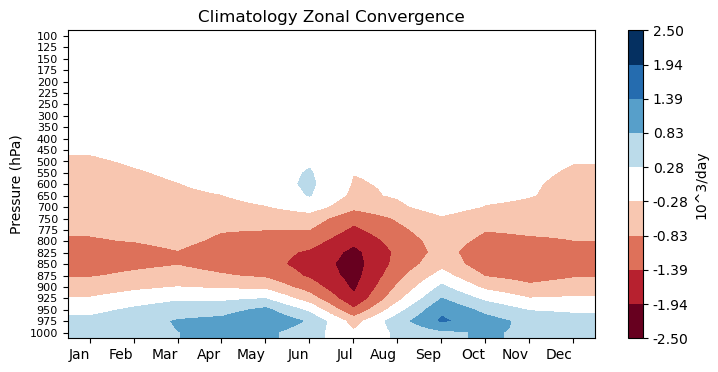

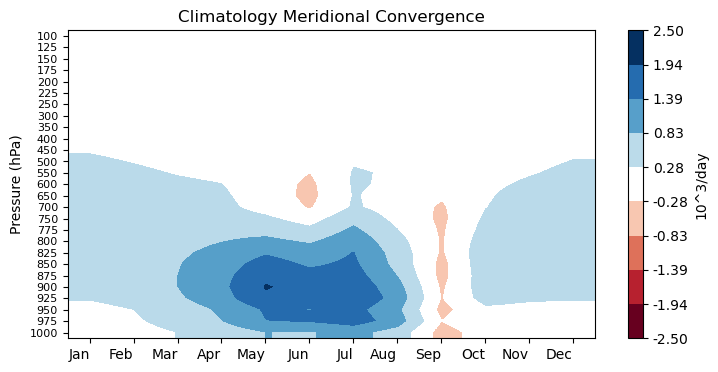

In [87]:
profs_to_plot = [zonal_convergence_profile, meridional_convergence_profile]

titles = ['Zonal', 'Meridional']

pressure_levels = full['level'].data

# levels = np.array([-1, -0.2, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.2, 1])
levels = np.linspace(-2.5, 2.5, 10)

colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', 'white', 'white', '#92c5de', '#4393c3', '#2166ac', '#053061']

cmap = mcolors.LinearSegmentedColormap.from_list("custom_coolwarm", colors, N=len(levels) - 1)

norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True)

# Subset pressure levels and data to go up to 100 hPa
pressure_subset = pressure_levels[pressure_levels >= 100]

pressure_indices = np.where(pressure_levels >= 100)[0]  # Get indices for subsetting the data

for i, arr in enumerate(profs_to_plot):
    
    plt.figure(figsize=(8.5, 4))
    
    # Subset data to match the pressure range up to 100 hPa
    hovmoller_data = np.array(arr)[:, pressure_indices]

    # Plot data without forcing extent to allow automatic scaling
    plt.imshow(hovmoller_data.T, aspect='auto', origin='lower', cmap=cmap, norm=norm, interpolation='bilinear')
    
    # Set x-axis labels
    plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
               ha='right')
    
    # Directly use the pressure subset for y-axis labels
    plt.yticks(np.arange(len(pressure_subset)), pressure_subset, size=8)

    plt.ylabel('Pressure (hPa)')

    # Color bar with custom tick labels
    cbar = plt.colorbar(label='10^3/day', ticks=levels)
    cbar.ax.set_yticklabels(['<-0.2', '-0.2', '-0.1', '-0.05', '-0.01', '0.01', '0.05', '0.1', '0.2', '>0.2'])

    cbar.ax.set_yticklabels([f"{level:.2f}" for level in levels])

    # Set title and show plot
    plt.title('Climatology {} Convergence'.format(titles[i]))
    plt.gca().invert_yaxis()
    plt.show()

## plotting advection Hovmoller diagrams below

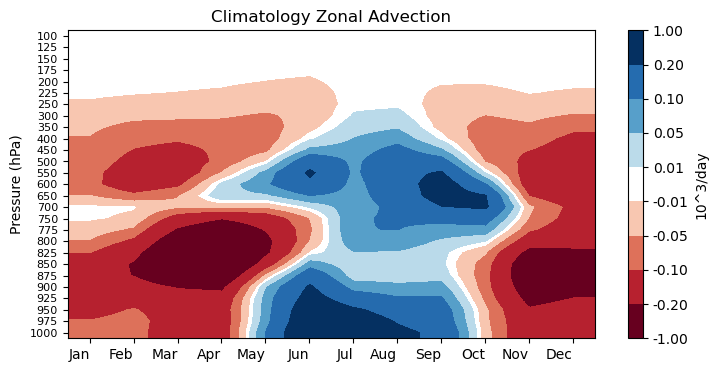

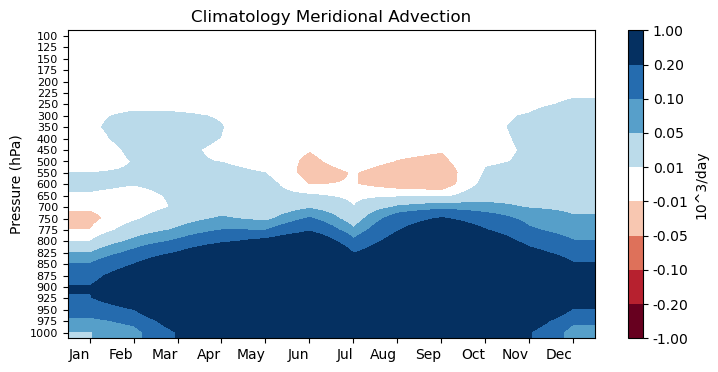

In [88]:
profs_to_plot = [zonal_advection_profile, meridional_advection_profile]

# Plotting the Hovmoller diagram of zonal and meridional advection 

titles = ['Zonal', 'Meridional']

pressure_levels = full['level'].data

levels = np.array([-1, -0.2, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.2, 1])
# levels = np.linspace(-2.5, 2.5, 10)

colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', 'white', 'white', '#92c5de', '#4393c3', '#2166ac', '#053061']

cmap = mcolors.LinearSegmentedColormap.from_list("custom_coolwarm", colors, N=len(levels) - 1)

norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True)

# Subset pressure levels and data to go up to 100 hPa
pressure_subset = pressure_levels[pressure_levels >= 100]

pressure_indices = np.where(pressure_levels >= 100)[0]  # Get indices for subsetting the data

for i, arr in enumerate(profs_to_plot):
    
    plt.figure(figsize=(8.5, 4))
    
    # Subset data to match the pressure range up to 100 hPa
    hovmoller_data = np.array(arr)[:, pressure_indices]

    # Plot data without forcing extent to allow automatic scaling
    plt.imshow(hovmoller_data.T, aspect='auto', origin='lower', cmap=cmap, norm=norm, interpolation='bilinear')
    
    # Set x-axis labels
    plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
               ha='right')
    
    # Directly use the pressure subset for y-axis labels
    plt.yticks(np.arange(len(pressure_subset)), pressure_subset, size=8)

    plt.ylabel('Pressure (hPa)')

    # Color bar with custom tick labels
    cbar = plt.colorbar(label='10^3/day', ticks=levels)
    cbar.ax.set_yticklabels(['<-0.2', '-0.2', '-0.1', '-0.05', '-0.01', '0.01', '0.05', '0.1', '0.2', '>0.2'])

    cbar.ax.set_yticklabels([f"{level:.2f}" for level in levels])

    # Set title and show plot
    plt.title('Climatology {} Advection'.format(titles[i]))
    plt.gca().invert_yaxis()
    plt.show()

## plotting MFC Hovmoller diagrams below

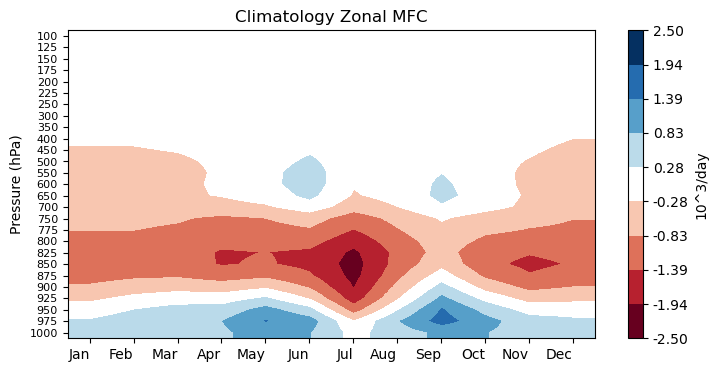

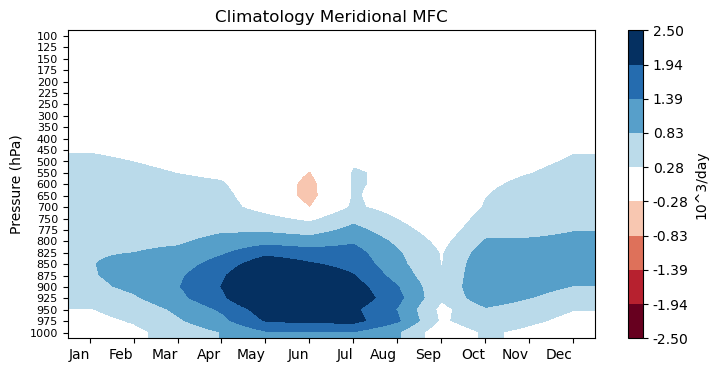

In [86]:
profs_to_plot = [zonal_mfc_profile, meridional_mfc_profile]

# Plotting the Hovmoller diagram of zonal and meridional advection 

titles = ['Zonal', 'Meridional']

pressure_levels = full['level'].data

# levels = np.array([-1, -0.2, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.2, 1])
levels = np.linspace(-2.5, 2.5, 10)

colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', 'white', 'white', '#92c5de', '#4393c3', '#2166ac', '#053061']

cmap = mcolors.LinearSegmentedColormap.from_list("custom_coolwarm", colors, N=len(levels) - 1)

norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True)

# Subset pressure levels and data to go up to 100 hPa
pressure_subset = pressure_levels[pressure_levels >= 100]

pressure_indices = np.where(pressure_levels >= 100)[0]  # Get indices for subsetting the data

for i, arr in enumerate(profs_to_plot):
    
    plt.figure(figsize=(8.5, 4))
    
    # Subset data to match the pressure range up to 100 hPa
    hovmoller_data = np.array(arr)[:, pressure_indices]

    # Plot data without forcing extent to allow automatic scaling
    plt.imshow(hovmoller_data.T, aspect='auto', origin='lower', cmap=cmap, norm=norm, interpolation='bilinear')
    
    # Set x-axis labels
    plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
               ha='right')
    
    # Directly use the pressure subset for y-axis labels
    plt.yticks(np.arange(len(pressure_subset)), pressure_subset, size=8)

    plt.ylabel('Pressure (hPa)')

    # Color bar with custom tick labels
    cbar = plt.colorbar(label='10^3/day', ticks=levels)
    cbar.ax.set_yticklabels(['<-0.2', '-0.2', '-0.1', '-0.05', '-0.01', '0.01', '0.05', '0.1', '0.2', '>0.2'])

    cbar.ax.set_yticklabels([f"{level:.2f}" for level in levels])

    # Set title and show plot
    plt.title('Climatology {} MFC'.format(titles[i]))
    plt.gca().invert_yaxis()
    plt.show()

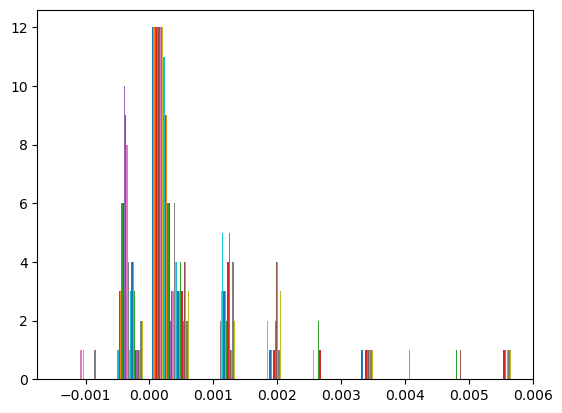

In [75]:
plt.hist(zonal_mfc_profile - (zonal_advection_profile+zonal_convergence_profile))
plt.show()